## Giancarlo's Implementation
https://github.com/giangamberi/Estudo-de-algoritmos-quanticos-e-suas-implementacoes/blob/main/EAQSI.ipynbhttps://dspace.mackenzie.br/items/071a8df2-1a8f-45c2-ab22-49749d06479b

In [98]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import AerProvider, AerSimulator
from qiskit.quantum_info import Statevector

from qiskit.providers.basic_provider import BasicProvider
from qiskit.quantum_info import Statevector

from qiskit.circuit.library import DiagonalGate
from qiskit.circuit.library import Diagonal
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

#plot
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import array_to_latex

def convertDiagonal(number, qubits):
    diagonalSize = pow(2,qubits)
    if (diagonalSize < number - 1): return -1 
    aux = np.ones(diagonalSize, dtype=int) # Criacao um array do tamanho da qtd de 2 qubits 
    aux[number] = -1
    return aux

def startSobreposition(qc: QuantumCircuit, qubits: list):
    for q in qubits: qc.h(q)
    return qc


# Aqui podemos imprimir o vetor de estados facilmente
def printStateVector(qc: QuantumCircuit) -> Statevector:
    qc.remove_final_measurements()  # no measurements allowed
    statevector = Statevector(qc)
    return array_to_latex(statevector, prefix="\\text{Statevector} = ")

def difusionMatrix(qc: QuantumCircuit, qubits: list, qubit_qtd: int):
    # Difusion => Hadamard . Diagonal . Hadamard
    # D = W R W
    R = np.ones(int(pow(2, len(qubits)))) # R = [1,1,1] c/ tamanho de qtd de qubits ** 2
    for i in range(1, pow(2, qubit_qtd)):
        R[i] = -1
    startSobreposition(qc, qubits)
    qc &= Diagonal(list(R))
    startSobreposition(qc, qubits)
    return qc




In [99]:
# Montagem da diagonal
qubit_qtd = 3
allQbits = [i for i in range(qubit_qtd)]

targetNumber = 0 # estado 100
groverDiagonal = list(convertDiagonal(targetNumber, qubit_qtd))
array_to_latex(groverDiagonal, prefix="\\text{Diagonal} = ")


<IPython.core.display.Latex object>

In [100]:
# Montagem do circuito inicial: Hadamard -> Diagonal


algoritmoGrover = QuantumCircuit(qubit_qtd)
algoritmoGrover = startSobreposition(algoritmoGrover, allQbits)
algoritmoGrover &= Diagonal(groverDiagonal)

print(algoritmoGrover)


     ┌───┐┌───────────┐
q_0: ┤ H ├┤0          ├
     ├───┤│           │
q_1: ┤ H ├┤1 Diagonal ├
     ├───┤│           │
q_2: ┤ H ├┤2          ├
     └───┘└───────────┘


# Vetor de Estados obtido após a construção do circuito

In [101]:
printStateVector(algoritmoGrover)

<IPython.core.display.Latex object>

In [102]:
# Criação da matriz de difusão
# W R W
mtx = QuantumCircuit(qubit_qtd)
mtx.Name = "difusionMatrix"
print(difusionMatrix(mtx, allQbits, qubit_qtd))


     ┌───┐┌───────────┐┌───┐
q_0: ┤ H ├┤0          ├┤ H ├
     ├───┤│           │├───┤
q_1: ┤ H ├┤1 Diagonal ├┤ H ├
     ├───┤│           │├───┤
q_2: ┤ H ├┤2          ├┤ H ├
     └───┘└───────────┘└───┘


In [103]:
# Aplicando matriz de difusao de Grover ao circuito

algoritmoGrover.append(mtx, allQbits)
algoritmoGrover.measure_all()
algoritmoGrover.draw()

┌───┐┌───────────┐┌──────────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0          ├┤0             ├─░─┤M├──────
        ├───┤│           ││              │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 Diagonal ├┤1 circuit-980 ├─░──╫─┤M├───
        ├───┤│           ││              │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2          ├┤2             ├─░──╫──╫─┤M├
        └───┘└───────────┘└──────────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════════╩══╩══╩═
                                              0  1  2

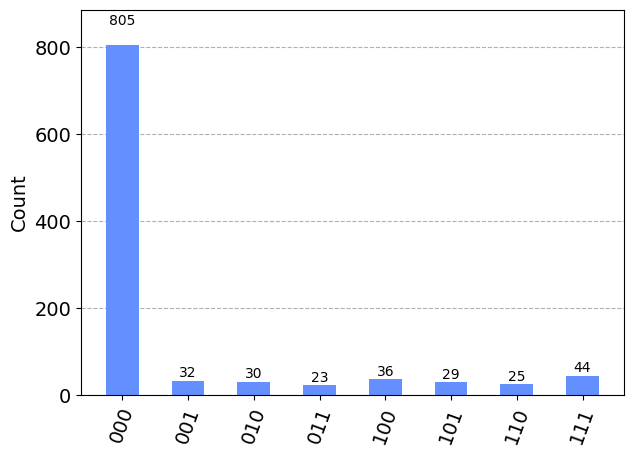

In [104]:
# Plot do resultado 
backend = BasicProvider().get_backend("basic_simulator")

transpiled_algoritmoGrover = transpile(algoritmoGrover, backend)
qobj = assemble(transpiled_algoritmoGrover)
result = backend.run(transpiled_algoritmoGrover).result()
count = result.get_counts()
plot_histogram(count)